# Find bragg stack parameters from normal reflection spectrum
Using TMM to generate reflectance with varying the parameters (thickness, RI) in a loop and calculate the least standard deviation with experimental data to get the best fit.

In [20]:
import matplotlib.pyplot as plt
from phc_codes.phc_utils import refractive_index
from phc_codes.spectra_utils import (
    load_spectra,
    clip_wl,
    plot_spectrum,
    smooth_spectrum,
)
from phc_codes.TMM import PhCTransferMatrix
from numpy import max, min, pi, std, array
# %matplotlib widget

## Refractive index data

In [21]:
n_scotch_tape = 1.5
n_quartz = (
    lambda x: (
        1
        + 0.6961663 / (1 - (0.0684043 / x) ** 2)
        + 0.4079426 / (1 - (0.1162414 / x) ** 2)
        + 0.8974794 / (1 - (9.896161 / x) ** 2)
    )
    ** 0.5
)  # Quartz #
npva = 1.457 + 0.0002j
npdms = lambda x : (1+1.0093/(1-13185.0/x**2))**.5 #1.427 + 0.0005j
npmma = lambda x : (1+0.99654/(1-0.00787/(x*1e3)**2)+0.18964/(1-0.02191/(x*1e3)**2)+0.00411/(1-3.85727/(x*1e3)**2))**.5
print(npdms(700))

1.4273084459471497


## input wavelength range and data file

In [22]:
wl1 = 350
wl2 = 990

refl_data = load_spectra(
        r"./data/PhC_refl.TXT",          #<<<<<< I/P
       # usecols=[0,3]
    )
theta_i = 0  # deg                                                      #<<<<<< I/P
theta_i *= pi / 180 #rad

smooth_data =    clip_wl(smooth_spectrum(refl_data, cut_freq=20),
    wl1,
    wl2
)
smooth_data[:, 1] -= min(smooth_data[:, 1])
smooth_data[:, 1] /= max(smooth_data[:, 1])
wls = smooth_data[:, 0]


## Define the structure

In [23]:
ni = 1.0
nsub = refractive_index("Quartz_expt")
nh = refractive_index("TiO2_expt")  # 2.41 + 0.0024j    #
nl = refractive_index("SiO2_expt")  # 1.46 + 0.0010j  #
n_m = refractive_index("Ag50nm")
th = 56                     
tl = 96
tf = 0
tmetal = 0

n_bilayer = 8
nn = array([n_m, npmma] + [nl, nh] * n_bilayer, dtype=object)  # R.I. of layers
#tt = array([tmetal, tpdms] + [th, tl] * n_bilayer)

## Transfer matrix for adjusing the paramerteres
### Find best fit for the thickness ranges

In [24]:
tls = range(97, 101)                       #<<<<<< I/P
ths = range(59, 69)                       #<<<<<< I/P
tfs = range(0, 1,)                      #<<<<<< I/P
diffs = []
diff = 100
for ttl in tls:
    for tth in ths:
        for ttf in  tfs:
          #tt = zeros(n_layer) + tl
          tt = array([tmetal, ttf] + [ttl, tth] * n_bilayer)# thickness of layers      #<<<<<< I/P
          #tt[2] = tl  / 2
          # tt[-1] = 1000  # buffer layer
          tr_matrix = PhCTransferMatrix(wls, ni, nn, nsub, tt, theta_i)
          # ax.plot(wls, tr_matrix.R)  # / max(tr_matrix.R))
          refl = tr_matrix.R
          refl /= max(refl)
          # find best fit by simply taking the summed absolute difference
          diff1 = std(refl - smooth_data[:, 1])
          if diff1 < diff:
             tl = ttl
             th = tth
             tf = ttf                                     #<<<<<<< I/P
             diff = diff1
          #diffs += [std(refl - smooth_data[:, 1])]

'''min_val_index = unravel_index(argmin(diffs), (len(tls), len(ths), len(tpdmss)))
tl = tls[min_val_index[0]]
th = ths[min_val_index[1]]
tpdms = tpdmss[min_val_index[2]]'''

'min_val_index = unravel_index(argmin(diffs), (len(tls), len(ths), len(tpdmss)))\ntl = tls[min_val_index[0]]\nth = ths[min_val_index[1]]\ntpdms = tpdmss[min_val_index[2]]'

## Redefine the thickness with the new values and calculate transfer matrix

In [25]:
tt = array([tmetal, tf] + [tl, th] * n_bilayer) # thickness of layers       #<<<<<< I/P
#tt[2] = tl  / 2
# tt[6] = tl * 3 / 2
# tt[-1] = 1000  # buffer layer

print(tt)
print("thickness of metal coat", tf)

# final calc with best fit parameters
tr_matrix = PhCTransferMatrix(wls, ni, nn, nsub, tt, theta_i)
refl = tr_matrix.R
refl /= max(refl)

[ 0  0 98 67 98 67 98 67 98 67 98 67 98 67 98 67 98 67]
thickness of metal coat 0


## Plot data as needed

<Figure size 1180x930 with 0 Axes>

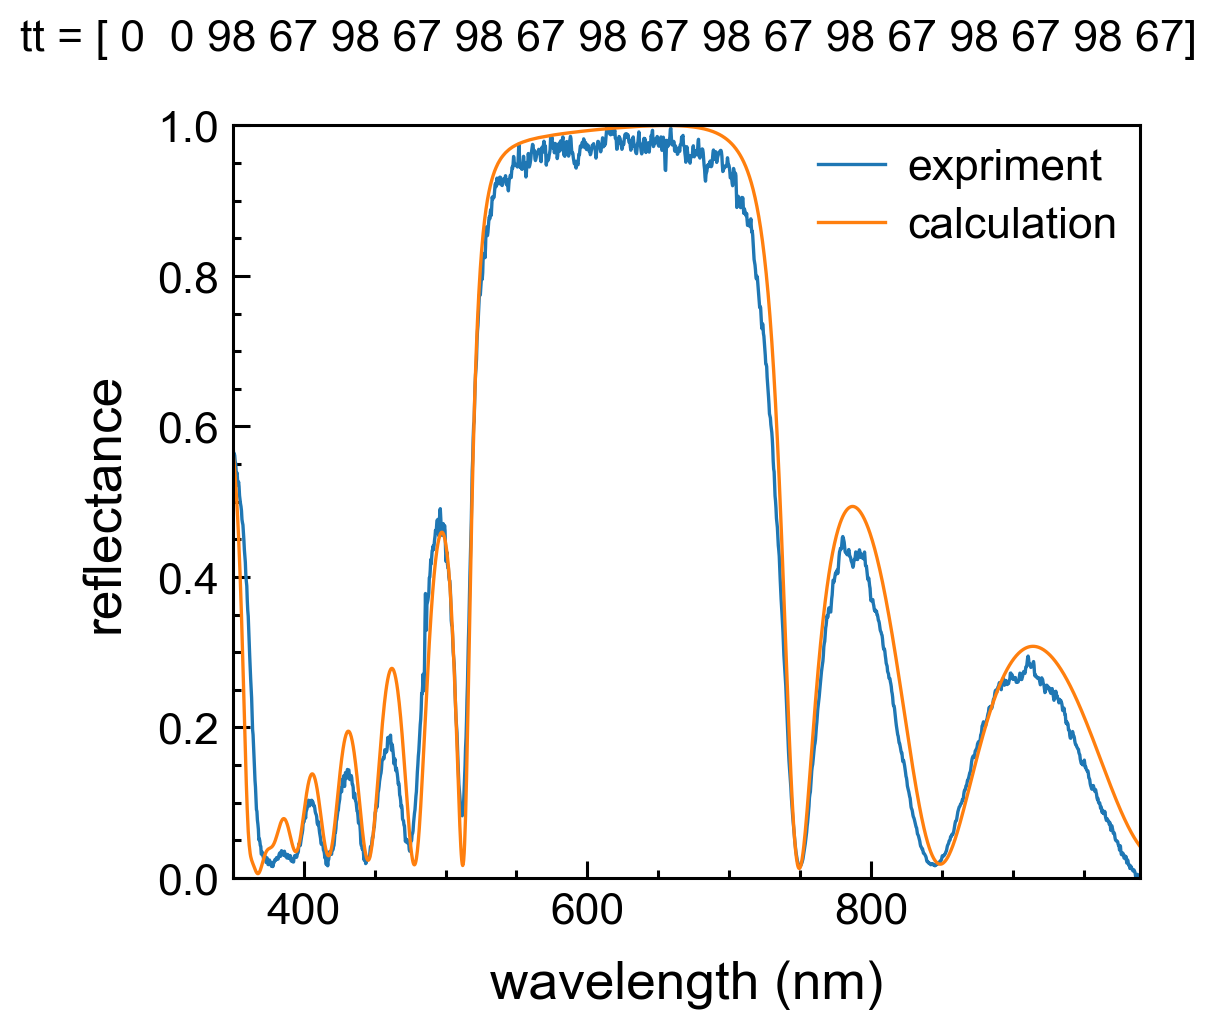

In [75]:
plt.clf()
fig, ax = plt.subplots()
plt.style.use("../plt_templates/originlike_lineplot.mplstyle")

# plot_spectrum(ax, refl_data)
ax = plot_spectrum(ax, smooth_data)
ax.plot(wls, refl)  # / max(tr_matrix.R))
plt.text(200, 1.1, f"tt = {tt}")
plt.legend(['expriment', 'calculation'])
plt.xlabel("wavelength (nm)")
plt.ylabel("reflectance")
#plt.text(750, 0.9, f"th={th}, tl={tl}, tpva={tpva}")
fig.savefig('./data/dip_coat_thickness.svg', format='svg')
plt.show()